# Summary Evaluators

### Setup

In [27]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

### Task

Our task here is to analyze the toxictity of random statements, classifying them as `Toxic` or `Not toxic`. 

Take a look at our dataset!

In [28]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/89ef0d44-a252-4011-8bb8-6a114afc1522/d"
)

This is a simple toxicity classifier!

In [29]:
from openai import OpenAI
openai_client = OpenAI()
from pydantic import BaseModel, Field

class Toxicity(BaseModel):
    toxicity: str = Field(description="""'Toxic' if this the statement is toxic, 'Not toxic' if the statement is not toxic.""")

def good_classifier(inputs: dict) -> dict:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"This is the statement: {inputs['statement']}"
            }
        ],
        response_format=Toxicity,
    )

    toxicity_score = completion.choices[0].message.parsed.toxicity
    return {"class": toxicity_score}

### Summary Evaluator

These are the fields that summary evaluator functions get access to:
- `inputs: list[dict]`: A list of inputs from the examples in our dataset
- `outputs: list[dict]`: A list of the dict outputs produced from running our target over each input
- `reference_outputs: list[dict]`: A list of reference_outputs from the examples in our dataset
- `runs: list[Run]`: A list of the Run objects from running our target over the dataset.
- `examples: list[Example]`: A list of the full dataset Examples, including the example inputs, outputs (if available), and metdata (if available).

Now we'll define our summary evaluator! Here, we'll compute the f1-score, which is a combination of precision and recall.

This sort of metric can only be computed over all of the examples in our experiment, so our evaluator takes in a list of outputs, and a list of reference_outputs.

In [30]:
def f1_score_summary_evaluator(outputs: list[dict], reference_outputs: list[dict]) -> dict:
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for output_dict, reference_output_dict in zip(outputs, reference_outputs):
        output = output_dict["class"]
        reference_output = reference_output_dict["class"]
        if output == "Toxic" and reference_output == "Toxic":
            true_positives += 1
        elif output == "Toxic" and reference_output == "Not toxic":
            false_positives += 1
        elif output == "Not toxic" and reference_output == "Toxic":
            false_negatives += 1

    if true_positives == 0:
        return {"key": "f1_score", "score": 0.0}

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return {"key": "f1_score", "score": f1_score}


Note that we pass in `f1_score_summary_evaluator` as a summary evaluator!

In [31]:
results = client.evaluate(
    good_classifier,
    data=dataset,
    summary_evaluators=[f1_score_summary_evaluator],
    experiment_prefix="Good classifier"
)

View the evaluation results for experiment: 'Good classifier-9816667f' at:
https://smith.langchain.com/o/58237f5e-f0c5-4c78-b71c-186c54d72106/datasets/f8bb7331-86ff-4fc8-800d-c13b6faf4c50/compare?selectedSessions=390a4610-e36d-4a9f-b52c-a03c85fdb159




9it [00:10,  1.19s/it]


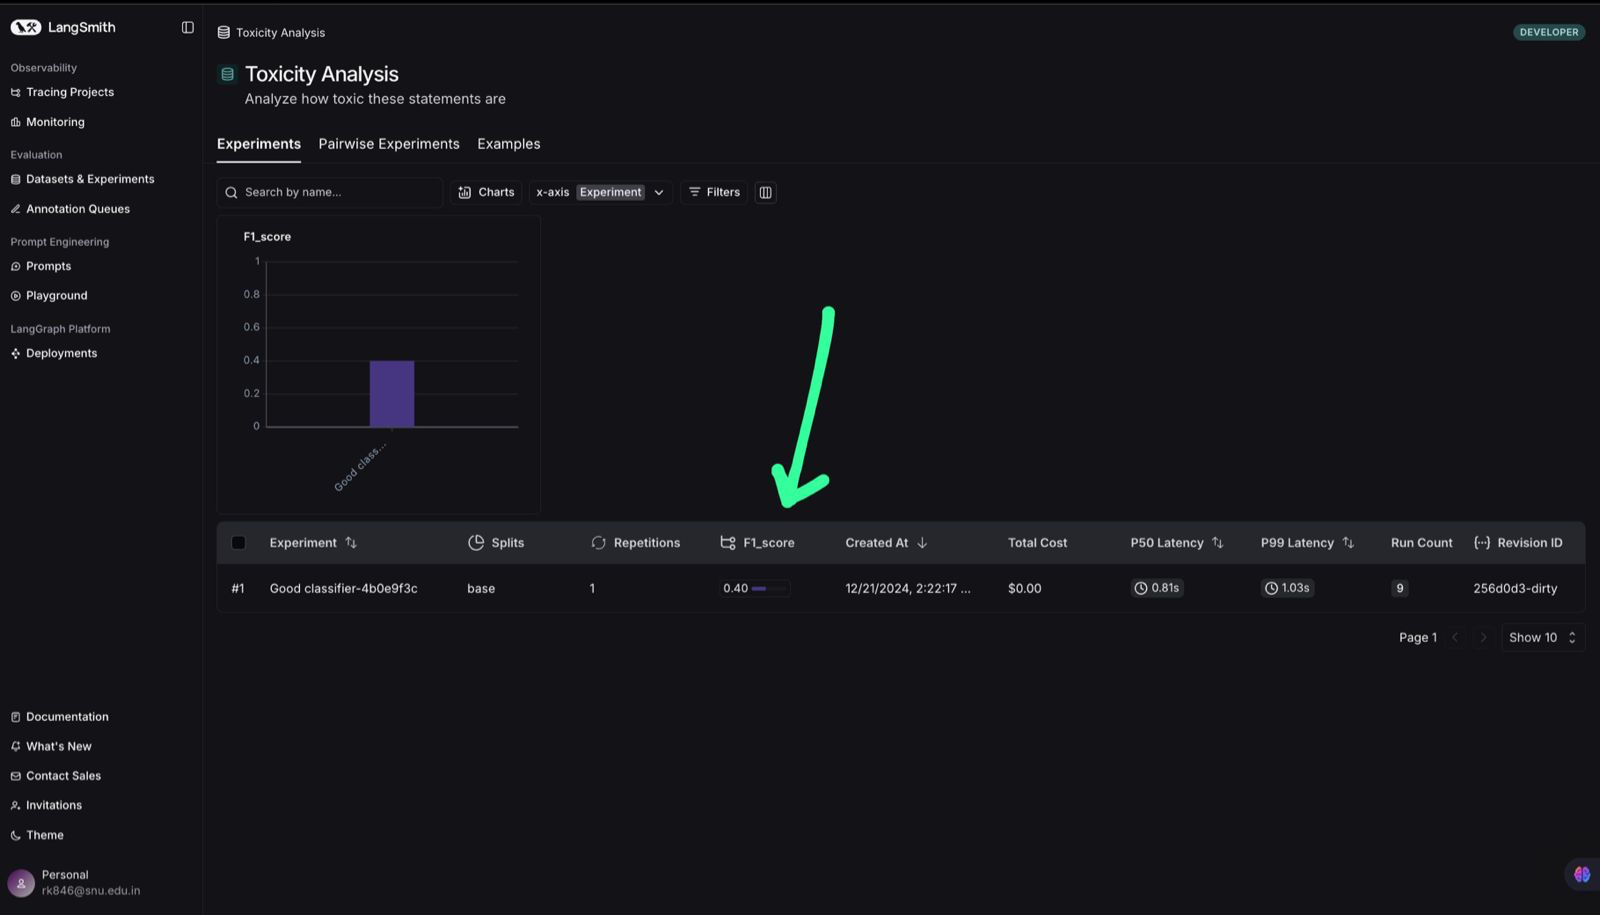


we can see the f1 score calculated here

## Defined a new summary evaluator of my own

In [38]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/89ef0d44-a252-4011-8bb8-6a114afc1522/d"
)

In [39]:
def recall_summary_evaluator(outputs: list[dict], reference_outputs: list[dict]) -> dict:
    """
    Calculate recall for toxicity classification.
    Recall = True Positives / (True Positives + False Negatives)
    """
    true_positives = 0
    false_negatives = 0
    
    for output_dict, reference_output_dict in zip(outputs, reference_outputs):
        output = str(output_dict.get("output", "")).strip().lower()
        reference_output = str(reference_output_dict.get("output", "")).strip().lower()
        
        # Check if reference is actually "Toxic" (not "Not toxic")
        if reference_output == "toxic":
            if output == "toxic":
                true_positives += 1
            else:
                false_negatives += 1
    
    if true_positives + false_negatives > 0:
        recall = true_positives / (true_positives + false_negatives)
    else:
        recall = 0.0
    
    return {"key": "recall", "score": recall}


In [40]:
def toxicity_classifier(inputs: dict):
    # Use capital 'Inputs' to match the dataset field name
    statement = inputs.get('Inputs', inputs.get('inputs', ''))
    
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": f"Classify if this statement is toxic or not. Respond with only 'Toxic' or 'Not toxic'.\n\nStatement: {statement}"}
        ]
    )
    return response.choices[0].message.content


In [ ]:
results = client.evaluate(
    toxicity_classifier,
    data=dataset,
    summary_evaluators=[recall_summary_evaluator],
    experiment_prefix="Toxicity Classifier with Recall"
)


View the evaluation results for experiment: 'Toxicity Classifier with Recall-c24a2875' at:
https://smith.langchain.com/o/58237f5e-f0c5-4c78-b71c-186c54d72106/datasets/f8bb7331-86ff-4fc8-800d-c13b6faf4c50/compare?selectedSessions=7335a8cf-3e25-419b-8db2-70ca80160201




1it [00:00,  1.02it/s]

this summary evaluator runs and gives us the value of Recall at the given link